##### Additional things done in this notebook
1. Replaced minmax scaler with standard scaler
2. Used CatBoost Classifier
3. Did PCA and XGBoost for the components selected by PCA
4. Used stacking 
5. Added a few data visualization graphics

#### PCA with XGboost gave accuracy of 83%. Catboost gives an accuracy of 81%. 

In [ ]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter
import random 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport
from dtreeviz.trees import dtreeviz # remember to load the package

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,RepeatedKFold, cross_val_score,KFold, RepeatedStratifiedKFold
from catboost import CatBoostClassifier

from sklearn import model_selection

#### load and partition data

In [ ]:
data_sampling_rate = 0.1
cv_folds = 10
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

In [ ]:
file_name = 'fashion-mnist_train.csv'
target_feature = "label"
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle_boot"}

In [ ]:
dataset = pd.read_csv(file_name)
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly


#dataset["sum"] = dataset.sum(axis=1)
#dataset["average"]=dataset.mean(axis=1)

display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
16265,4,0,0,0,0,0,0,0,0,0,...,0,0,0,54,123,123,0,0,0,0
49108,2,0,0,0,0,0,6,0,0,0,...,71,22,0,0,168,205,187,57,0,0
48717,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1488,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39804,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = dataset[dataset.columns[1:]]
Y = np.array(dataset[target_feature])

In [ ]:
dataset[target_feature].value_counts()
#examinig the distrubution of data


2    626
7    611
9    611
6    606
4    600
8    598
0    595
3    590
1    585
5    578
Name: label, dtype: int64

In [ ]:
print(X)
print(Y)


       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
16265       0       0       0       0       0       0       0       0       0   
49108       0       0       0       0       0       6       0       0       0   
48717       0       0       0       0       0       0       0       0       0   
1488        0       0       0       0       0       0       0       0       0   
39804       0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
37109       0       0       0       0       0       0       0       0      19   
58624       0       0       0       0       0       0       0      43      68   
45070       0       0       0       0       0       0       0       0      47   
15534       0       0       0       0       0       0       0       0       0   
53958       0       0       0       0       0       0       0       0       0   

       pixel10  ...  pixel7

In [ ]:
#summary statistic of each feature
if(dataset.select_dtypes(include=[np.number]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.number]).describe().transpose())
if(dataset.select_dtypes(include=[np.object]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.object]).describe().transpose())

,count,mean,std,min,25%,50%,75%,max
label,6000.0,4.515500,2.876248,0.0,2.0,5.0,7.0,9.0
pixel1,6000.0,0.002333,0.180739,0.0,0.0,0.0,0.0,14.0
pixel2,6000.0,0.011000,0.294777,0.0,0.0,0.0,0.0,15.0
pixel3,6000.0,0.036000,0.766682,0.0,0.0,0.0,0.0,52.0
pixel4,6000.0,0.101000,1.805919,0.0,0.0,0.0,0.0,64.0
...,...,...,...,...,...,...,...,...
pixel780,6000.0,18.183833,45.144509,0.0,0.0,0.0,0.0,243.0
pixel781,6000.0,8.285000,29.395977,0.0,0.0,0.0,0.0,244.0
pixel782,6000.0,2.869667,18.034353,0.0,0.0,0.0,0.0,225.0
pixel783,6000.0,1.005167,10.629611,0.0,0.0,0.0,0.0,255.0


In [ ]:
# Check for presence of missing values
print("Missing Values")
print(dataset.isnull().sum().sort_values(ascending = False))

Missing Values
pixel784    0
pixel268    0
pixel266    0
pixel265    0
pixel264    0
           ..
pixel520    0
pixel519    0
pixel518    0
pixel517    0
label       0
Length: 785, dtype: int64


##### Isolate descriptive features

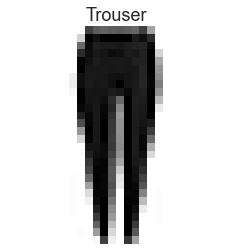

In [ ]:
plt.imshow((X.iloc[8]).values.astype('int').reshape(28,28), cmap=plt.cm.binary, vmin=0, vmax=255)
plt.title((str(classes[Y[8]])))
plt.axis("off")
plt.show()


In [ ]:
pltsize=4
row_images = 10
col_images = 10
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow((X.iloc[i_rand]).values.astype('int').reshape(5,5), cmap='gray', vmin=0, vmax=255)
    plt.title((str(classes[Y[i_rand]])))
    # print('Training sample',i_rand,': class:',y_train[i_rand])

In [ ]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, \
                       shuffle=True, \
                       stratify = Y, \
                       train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, y_train_plus_valid, \
                        shuffle=True, \
                        stratify = y_train_plus_valid, \
                        train_size = 0.5/0.7)

In [ ]:
print(X_train)
print(X_test)

       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
26928       0       0       0       0       0       0       0       0       1   
2977        0       0       0       0       0       0       0       1       0   
49027       0       0       0       0       1       0       1       0       0   
1417        0       6       6       4       3       8       0       0       0   
32255       0       0       0       0       1       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
33076       0       0       0       0       0       0       0       0       0   
40899       0       0       0       0       0       0       0       0       0   
23949       0       0       0       0       0       0       0       0       0   
28375       0       0       0       0       0       0       0       0       0   
10146       0       0       0       0       0       0       0       0       0   

       pixel10  ...  pixel7

#### Standard scaling and PCA 

[[ 0.         -0.03869188 -0.04463555 ... -0.16297162 -0.0972939
  -0.04001317]
 [ 0.         -0.03869188 -0.04463555 ... -0.16297162 -0.0972939
  -0.04001317]
 [ 0.         -0.03869188 -0.04463555 ... -0.16297162 -0.0972939
  -0.04001317]
 ...
 [ 0.         -0.03869188 -0.04463555 ... -0.16297162 -0.0972939
  -0.04001317]
 [ 0.         -0.03869188 -0.04463555 ... -0.16297162 -0.0972939
  -0.04001317]
 [ 0.         -0.03869188 -0.04463555 ... -0.16297162 -0.0972939
  -0.04001317]]


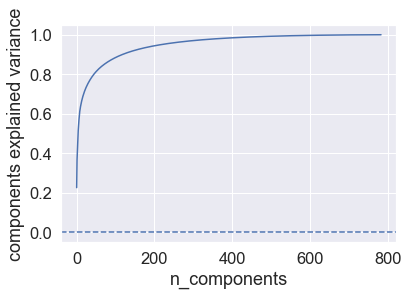

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

print(X_train_scaled)
a = scaler.fit_transform(X_train)

# Little trick to stop transform from pandas daataframe to numpy array losing column namesWatch out for putting back in columns here
cols = X_train.columns
X_train = pd.DataFrame(a, columns = cols) 

# Also normalise other partitions
a =  scaler.fit_transform(X_train_plus_valid)
X_train_plus_valid = pd.DataFrame(a, columns = cols) 
a =  scaler.fit_transform(X_valid)
X_valid = pd.DataFrame(a, columns = cols) 
a =  scaler.transform(X_test)
X_test = pd.DataFrame(a, columns = cols) 




pca=PCA()
pca.fit(X_train_scaled)

#print('Variance explained by the principal components(in decreasing order):\n',pca.explained_variance_ratio_)

cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots()

ax.plot(range(pca.n_components_), cum_exp_var)
ax.axhline(y=0,linestyle="--")
ax.set_xlabel("n_components")
ax.set_ylabel("components explained variance")

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

#### XGBOOST to see result of PCA

C:\Users\kshit\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:03:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB Classifier: 83.00


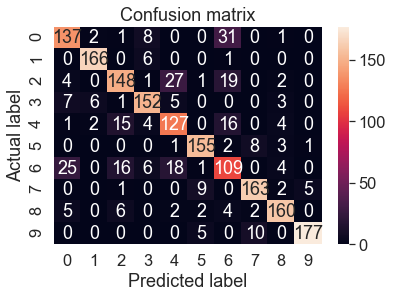

In [ ]:
from xgboost import XGBClassifier, plot_importance,to_graphviz

# fit model on training data
param = {'max_depth': 3, 'eta': 0.8, 'subsample':1, 'objective': 'binary:logistic'}
xgb = XGBClassifier(**param)
xgb.fit(X_pca, y_train)
# make predictions for test data
y_pred = xgb.predict(X_pca_test)

# evaluate predictions
xgb_score = accuracy_score(y_test, y_pred)
print("Accuracy of XGB Classifier: {0:0.2f}".format(xgb_score * 100.0));

def confusion_mat(y_pred,y_test):
    plt.figure()
    sns.set(font_scale=1.5)
    cm = confusion_matrix(y_pred, y_test)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
#Plot the confusion matrix
confusion_mat(y_pred, y_test)



In [ ]:
display(X_train)

display(X_test)
#summary statistic of each feature
if(X_train.select_dtypes(include=[np.number]).shape[1] > 0):
    display(X_train.select_dtypes(include=[np.number]).describe().transpose())
if(X_train.select_dtypes(include=[np.object]).shape[1] > 0):
    display(X_train.select_dtypes(include=[np.object]).describe().transpose())


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,-0.038692,-0.044636,-0.054123,-0.069685,-0.079941,-0.099227,-0.154018,-0.188901,-0.363388,...,0.333832,-0.469952,-0.381298,-0.410183,-0.448388,-0.401378,-0.284384,-0.162972,-0.097294,-0.040013
1,0.0,-0.038692,-0.044636,-0.054123,-0.069685,-0.079941,-0.099227,-0.055183,-0.236695,-0.363388,...,-0.601602,-0.469952,-0.381298,-0.410183,0.164941,1.599622,1.943341,-0.162972,-0.097294,-0.040013
2,0.0,-0.038692,-0.044636,-0.054123,0.273030,-0.079941,0.077438,-0.154018,-0.236695,-0.363388,...,-0.548653,-0.469952,-0.381298,3.653184,3.864081,2.355556,-0.284384,-0.162972,-0.097294,-0.040013
3,0.0,18.289042,5.735508,2.663350,0.958460,1.991964,-0.099227,-0.154018,-0.236695,0.533290,...,-0.531003,-0.323593,-0.234517,-0.177991,-0.448388,-0.334678,-0.055060,0.148936,0.407255,4.277954
4,0.0,-0.038692,-0.044636,-0.054123,0.273030,-0.079941,-0.099227,-0.154018,-0.236695,0.393184,...,2.345897,1.725436,-0.381298,-0.410183,-0.448388,-0.401378,-0.284384,-0.162972,-0.097294,-0.040013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,-0.038692,-0.044636,-0.054123,-0.069685,-0.079941,-0.099227,-0.154018,-0.236695,-0.363388,...,-0.601602,-0.469952,-0.381298,-0.410183,-0.448388,-0.401378,-0.284384,-0.162972,-0.097294,-0.040013
2996,0.0,-0.038692,-0.044636,-0.054123,-0.069685,-0.079941,-0.099227,-0.154018,-0.236695,-0.363388,...,-0.601602,-0.469952,-0.381298,-0.410183,-0.448388,-0.401378,-0.284384,-0.162972,-0.097294,-0.040013
2997,0.0,-0.038692,-0.044636,-0.054123,-0.069685,-0.079941,-0.099227,-0.154018,-0.236695,-0.363388,...,-0.601602,-0.469952,-0.381298,-0.410183,-0.448388,-0.401378,-0.284384,-0.162972,-0.097294,-0.040013
2998,0.0,-0.038692,-0.044636,-0.054123,-0.069685,-0.079941,-0.099227,-0.154018,-0.236695,-0.335367,...,-0.531003,-0.386319,-0.381298,1.702768,3.844914,1.421755,-0.284384,-0.162972,-0.097294,-0.040013


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,-0.038759,-0.107808,-0.058858,-0.055064,-0.084065,-0.091507,-0.169062,-0.236008,-0.379405,...,1.092956,1.742930,0.636753,-0.434884,-0.467790,-0.410101,-0.278338,-0.161072,-0.096981,-0.048909
1,0.0,-0.038759,-0.107808,-0.058858,-0.055064,-0.084065,-0.091507,-0.169062,-0.236008,5.131845,...,-0.608233,-0.468846,-0.398936,-0.434884,-0.467790,-0.410101,-0.278338,-0.161072,-0.096981,-0.048909
2,0.0,-0.038759,-0.107808,-0.058858,-0.055064,-0.084065,-0.091507,-0.169062,-0.236008,-0.379405,...,-0.608233,-0.468846,-0.398936,-0.434884,-0.467790,-0.410101,-0.278338,-0.161072,-0.096981,-0.048909
3,0.0,-0.038759,-0.107808,0.942977,-0.055064,-0.084065,-0.091507,1.128182,0.916254,2.078664,...,0.693697,0.958755,0.989829,0.740381,-0.449134,-0.410101,-0.278338,-0.161072,-0.096981,-0.048909
4,0.0,-0.038759,-0.107808,-0.058858,-0.055064,-0.084065,-0.091507,-0.169062,-0.236008,1.147185,...,0.884647,-0.468846,-0.398936,-0.434884,-0.467790,-0.410101,-0.278338,-0.161072,-0.096981,-0.048909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.0,-0.038759,-0.107808,-0.058858,-0.055064,-0.084065,-0.091507,-0.169062,-0.236008,-0.379405,...,0.780493,0.375650,-0.398936,-0.434884,-0.467790,-0.410101,-0.278338,-0.161072,-0.096981,-0.048909
1796,0.0,-0.038759,-0.107808,-0.058858,-0.055064,-0.084065,-0.091507,-0.169062,-0.236008,-0.379405,...,-0.608233,-0.448739,-0.398936,-0.434884,0.315747,0.246908,0.907193,2.952663,-0.096981,-0.048909
1797,0.0,-0.038759,-0.107808,-0.058858,-0.055064,-0.084065,-0.091507,-0.169062,-0.236008,-0.379405,...,-0.608233,-0.468846,-0.398936,-0.434884,-0.467790,-0.410101,-0.278338,-0.161072,-0.096981,-0.048909
1798,0.0,-0.038759,-0.107808,-0.058858,-0.055064,-0.084065,-0.091507,-0.169062,-0.236008,-0.379405,...,-0.608233,-0.468846,-0.398936,-0.434884,-0.467790,-0.410101,-0.278338,-0.161072,-0.096981,-0.048909


,count,mean,std,min,25%,50%,75%,max
pixel1,3000.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pixel2,3000.0,2.641221e-16,1.000167,-0.038692,-0.038692,-0.038692,-0.038692,45.780644
pixel3,3000.0,5.757940e-16,1.000167,-0.044636,-0.044636,-0.044636,-0.044636,50.049939
pixel4,3000.0,1.766041e-16,1.000167,-0.054123,-0.054123,-0.054123,-0.054123,37.311135
pixel5,3000.0,-1.883216e-16,1.000167,-0.069685,-0.069685,-0.069685,-0.069685,28.032967
...,...,...,...,...,...,...,...,...
pixel780,3000.0,-1.721586e-16,1.000167,-0.401378,-0.401378,-0.401378,-0.401378,4.934623
pixel781,3000.0,-3.454274e-16,1.000167,-0.284384,-0.284384,-0.284384,-0.284384,7.709219
pixel782,3000.0,2.192135e-16,1.000167,-0.162972,-0.162972,-0.162972,-0.162972,11.533556
pixel783,3000.0,1.376769e-16,1.000167,-0.097294,-0.097294,-0.097294,-0.097294,21.346045


#### vizualisation 

Text(0, 0.5, 'Label')

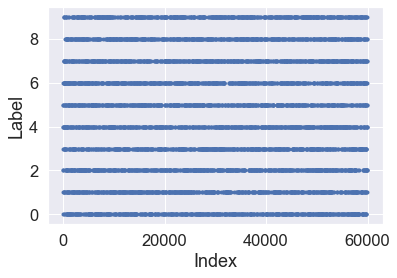

In [ ]:
#check if the data is shuffled
plt.figure()
plt.plot(dataset.label,'.')
plt.xlabel('Index')
plt.ylabel('Label')

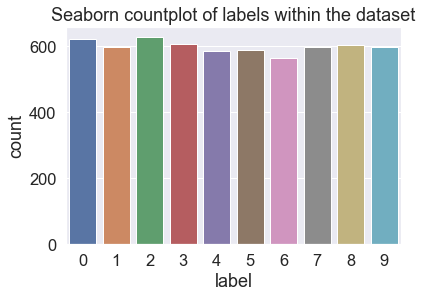

In [ ]:
#to check the skeweness of target feature's classes
plt.figure()
ax = sns.countplot(data=dataset, x='label');
ax.set_title("Seaborn countplot of labels within the dataset");

## Building Simple Models


In [ ]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy")
my_tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

#### Evaluating performance

In [ ]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       292
           2       1.00      1.00      1.00       313
           3       1.00      1.00      1.00       295
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       289
           6       1.00      1.00      1.00       303
           7       1.00      1.00      1.00       306
           8       1.00      1.00      1.00       299
           9       1.00      1.00      1.00       306

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,297,0,0,0,0,0,0,0,0,0,297
1,0,292,0,0,0,0,0,0,0,0,292
2,0,0,313,0,0,0,0,0,0,0,313
3,0,0,0,295,0,0,0,0,0,0,295
4,0,0,0,0,300,0,0,0,0,0,300
5,0,0,0,0,0,289,0,0,0,0,289
6,0,0,0,0,0,0,303,0,0,0,303
7,0,0,0,0,0,0,0,306,0,0,306
8,0,0,0,0,0,0,0,0,299,0,299


In [ ]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_valid, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.705
              precision    recall  f1-score   support

           0       0.64      0.71      0.68       119
           1       0.88      0.91      0.90       117
           2       0.64      0.49      0.55       125
           3       0.68      0.71      0.70       118
           4       0.59      0.62      0.60       120
           5       0.80      0.78      0.79       116
           6       0.39      0.42      0.41       121
           7       0.78      0.81      0.80       122
           8       0.87      0.85      0.86       120
           9       0.79      0.76      0.78       122

    accuracy                           0.70      1200
   macro avg       0.71      0.71      0.71      1200
weighted avg       0.71      0.70      0.70      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,85,0,2,10,1,1,20,0,0,0,119
1,2,107,0,6,0,1,1,0,0,0,117
2,8,0,61,3,25,0,27,0,1,0,125
3,6,11,3,84,4,0,9,0,1,0,118
4,2,2,14,7,74,0,19,0,1,1,120
5,1,0,0,0,0,90,0,14,4,7,116
6,26,0,14,9,17,0,51,0,3,1,121
7,0,0,0,0,0,6,0,99,3,14,122
8,1,0,1,3,4,3,3,2,102,1,120


In [ ]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7222222222222222
              precision    recall  f1-score   support

           0       0.65      0.68      0.66       179
           1       0.91      0.88      0.89       176
           2       0.57      0.45      0.50       188
           3       0.72      0.76      0.74       177
           4       0.60      0.58      0.59       180
           5       0.83      0.87      0.85       173
           6       0.40      0.51      0.45       182
           7       0.83      0.86      0.84       183
           8       0.88      0.81      0.85       179
           9       0.92      0.86      0.89       183

    accuracy                           0.72      1800
   macro avg       0.73      0.72      0.73      1800
weighted avg       0.73      0.72      0.72      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,121,2,7,10,1,0,36,0,2,0,179
1,5,154,0,11,3,0,3,0,0,0,176
2,8,0,85,3,39,1,47,0,5,0,188
3,11,10,2,134,5,1,13,0,1,0,177
4,3,2,30,12,104,0,28,0,1,0,180
5,1,0,0,2,0,150,0,12,4,4,173
6,35,0,24,12,13,1,93,0,4,0,182
7,0,0,0,0,0,16,0,157,2,8,183
8,2,2,2,1,7,4,12,2,145,2,179


### Less Overiftted Decision Tree

In [ ]:
dtree = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split = 200)
dtree = dtree.fit(X_train,y_train)

In [ ]:
# Make a set of predictions for the t raining data
y_pred = dtree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7446666666666667
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       297
           1       0.99      0.83      0.90       292
           2       0.62      0.78      0.69       313
           3       0.66      0.69      0.68       295
           4       0.79      0.43      0.56       300
           5       0.69      0.91      0.79       289
           6       0.48      0.55      0.51       303
           7       0.90      0.83      0.86       306
           8       0.80      0.79      0.79       299
           9       0.89      0.90      0.89       306

    accuracy                           0.74      3000
   macro avg       0.76      0.74      0.74      3000
weighted avg       0.76      0.74      0.74      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,223,0,6,16,0,0,49,0,3,0,297
1,1,241,4,43,0,1,1,0,1,0,292
2,3,0,244,0,23,1,23,0,19,0,313
3,10,2,5,203,0,33,41,0,1,0,295
4,3,0,68,35,130,0,61,0,3,0,300
5,1,0,0,2,0,262,0,10,3,11,289
6,25,0,68,7,12,0,167,0,24,0,303
7,0,0,0,0,0,29,0,253,1,23,306
8,11,0,0,0,0,43,9,0,236,0,299


In [ ]:
# Make a set of predictions for the test data
y_pred = dtree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.6866666666666666
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       119
           1       0.99      0.84      0.91       117
           2       0.65      0.74      0.69       125
           3       0.66      0.68      0.67       118
           4       0.73      0.42      0.54       120
           5       0.59      0.79      0.68       116
           6       0.40      0.53      0.46       121
           7       0.81      0.74      0.77       122
           8       0.73      0.68      0.71       120
           9       0.81      0.80      0.80       122

    accuracy                           0.69      1200
   macro avg       0.71      0.69      0.69      1200
weighted avg       0.71      0.69      0.69      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,77,0,1,9,0,0,29,0,3,0,119
1,2,98,1,13,0,2,1,0,0,0,117
2,0,0,93,1,13,0,12,0,6,0,125
3,4,1,1,80,0,9,22,0,1,0,118
4,0,0,21,11,51,0,31,0,6,0,120
5,1,0,0,2,0,92,0,10,2,9,116
6,16,0,26,4,5,0,64,0,6,0,121
7,0,0,0,0,0,17,0,90,2,13,122
8,7,0,0,1,1,27,1,0,82,1,120


In [ ]:
# Make a set of predictions for the test data
y_pred = dtree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.6888888888888889
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       179
           1       0.97      0.73      0.83       176
           2       0.55      0.66      0.60       188
           3       0.60      0.72      0.66       177
           4       0.63      0.37      0.47       180
           5       0.67      0.90      0.77       173
           6       0.41      0.46      0.43       182
           7       0.87      0.79      0.83       183
           8       0.73      0.77      0.75       179
           9       0.91      0.86      0.89       183

    accuracy                           0.69      1800
   macro avg       0.71      0.69      0.69      1800
weighted avg       0.70      0.69      0.69      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,111,3,9,13,0,0,38,0,5,0,179
1,4,129,3,35,0,2,3,0,0,0,176
2,4,0,124,1,26,1,13,0,19,0,188
3,5,0,4,128,0,15,24,0,1,0,177
4,1,0,45,24,67,0,39,0,4,0,180
5,1,0,0,4,0,156,0,6,2,4,173
6,25,1,37,7,13,0,84,0,15,0,182
7,0,0,0,0,0,24,0,145,3,11,183
8,5,0,3,1,1,25,4,1,138,1,179


#### Choosing parameters using Grid Search CV

In [ ]:
dtree = tree.DecisionTreeClassifier(max_depth = 12)
scores = cross_val_score(dtree, X_train_plus_valid, y_train_plus_valid, cv=10)
print(scores)

[0.72857143 0.73095238 0.73095238 0.75952381 0.67380952 0.72857143
 0.76190476 0.77380952 0.72142857 0.77142857]


In [ ]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, verbose = 2, \
                            return_train_score=True, n_jobs = -1)
my_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.1min finished


Best parameters set found on development set:


{'criterion': 'entropy', 'max_depth': 39, 'min_samples_split': 200}

0.7247619047619047

{'mean_fit_time': array([0.59611409, 1.0644767 , 1.40137849, 2.15067613, 2.63772929,
        2.70873358, 2.77793005, 2.57151446, 2.46703656, 2.6804827 ,
        2.67154436, 2.81070349, 2.75037825, 2.72532969, 2.87300074,
        2.70986066, 1.60779603, 3.67873776, 3.64942181, 3.9898037 ,
        3.76592658, 3.65399306, 3.8669203 , 3.7348155 , 3.76865215,
        3.46897509, 3.53371513, 3.45843585, 3.4772295 , 3.47782686,
        3.57389321, 3.6559551 ]),
 'std_fit_time': array([0.03149991, 0.06630671, 0.09621446, 0.2553026 , 0.16129301,
        0.22509836, 0.17355272, 0.15766104, 0.10235333, 0.2485713 ,
        0.25350023, 0.21108985, 0.15734159, 0.19020241, 0.18836508,
        0.19853502, 0.11963287, 0.18058358, 0.23688586, 0.32910539,
        0.18369157, 0.28113119, 0.28235225, 0.23246441, 0.29243992,
        0.16052664, 0.14840934, 0.14523639, 0.15538853, 0.26175947,
        0.36903646, 0.51605808]),
 'mean_score_time': array([0.01269646, 0.01288118, 0.01314831, 0.01769197, 0.023710

In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6688888888888889
              precision    recall  f1-score   support

           0       0.80      0.60      0.69       179
           1       0.89      0.91      0.90       176
           2       0.55      0.65      0.60       188
           3       0.53      0.80      0.64       177
           4       0.56      0.54      0.55       180
           5       0.79      0.84      0.81       173
           6       0.32      0.41      0.36       182
           7       0.88      0.85      0.86       183
           8       0.85      0.22      0.35       179
           9       0.87      0.87      0.87       183

    accuracy                           0.67      1800
   macro avg       0.70      0.67      0.66      1800
weighted avg       0.70      0.67      0.66      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,108,3,14,35,0,0,18,0,0,1,179
1,0,160,3,12,1,0,0,0,0,0,176
2,1,0,122,2,50,0,10,0,3,0,188
3,2,16,4,141,2,10,2,0,0,0,177
4,0,0,36,28,98,0,18,0,0,0,180
5,0,0,0,13,0,145,1,6,0,8,173
6,24,0,36,20,22,1,75,0,4,0,182
7,0,0,0,0,0,10,5,156,0,12,183
8,0,0,7,13,2,12,102,1,39,3,179


#### Comparing models

#### Random Forest


In [ ]:
# Do the same job with random forests
my_model = ensemble.RandomForestClassifier(n_estimators=300, \
                                           max_features = 3,\
                                           min_samples_split=200)
my_model.fit(X_train,y_train)


RandomForestClassifier(max_features=3, min_samples_split=200, n_estimators=300)

In [ ]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.745
              precision    recall  f1-score   support

           0       0.53      0.93      0.67       119
           1       1.00      0.82      0.90       117
           2       0.61      0.71      0.66       125
           3       0.81      0.66      0.73       118
           4       0.64      0.58      0.61       120
           5       0.97      0.72      0.83       116
           6       0.66      0.35      0.45       121
           7       0.84      0.77      0.80       122
           8       0.89      0.94      0.91       120
           9       0.76      0.96      0.85       122

    accuracy                           0.74      1200
   macro avg       0.77      0.75      0.74      1200
weighted avg       0.77      0.74      0.74      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,111,0,4,3,0,0,0,0,1,0,119
1,12,96,1,8,0,0,0,0,0,0,117
2,2,0,89,0,21,0,10,0,3,0,125
3,33,0,2,78,1,0,3,0,1,0,118
4,8,0,31,2,70,0,9,0,0,0,120
5,0,0,0,0,0,84,0,15,3,14,116
6,43,0,16,0,18,0,42,0,2,0,121
7,0,0,0,0,0,3,0,94,3,22,122
8,1,0,2,4,0,0,0,0,113,0,120


In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(100, 501, 50)), 'max_features': list(range(2, 10, 2)), 'min_samples_split': [200] }
]

# Perform the search
my_tuned_rf = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv=cv_folds, verbose = 2, n_jobs = -1)
my_tuned_rf.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_rf.best_params_)
model_tuned_params_list["Tuned Random Forest"] = my_tuned_rf.best_params_
print(my_tuned_rf.best_score_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished


Best parameters set found on development set:
{'max_features': 8, 'min_samples_split': 200, 'n_estimators': 300}
0.790952380952381


In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_rf.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7872222222222223
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       179
           1       1.00      0.82      0.90       176
           2       0.65      0.70      0.68       188
           3       0.73      0.90      0.81       177
           4       0.67      0.68      0.68       180
           5       0.96      0.92      0.94       173
           6       0.58      0.29      0.39       182
           7       0.92      0.85      0.88       183
           8       0.81      0.93      0.86       179
           9       0.87      0.97      0.92       183

    accuracy                           0.79      1800
   macro avg       0.79      0.79      0.78      1800
weighted avg       0.79      0.79      0.78      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,148,0,8,12,0,0,3,0,8,0,179
1,1,144,3,24,3,0,1,0,0,0,176
2,1,0,132,1,33,0,11,0,10,0,188
3,7,0,0,160,1,0,7,0,2,0,177
4,4,0,26,11,123,0,13,0,3,0,180
5,0,0,0,0,0,159,0,6,3,5,173
6,57,0,32,6,21,1,53,0,12,0,182
7,0,0,0,0,0,6,0,155,1,21,183
8,0,0,2,4,2,0,4,1,166,0,179


#### Bagging

In [ ]:
# Do the same job with random forests
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                      n_estimators=10)
my_model.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=50))

In [ ]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7541666666666667
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       119
           1       0.97      0.89      0.93       117
           2       0.74      0.69      0.71       125
           3       0.74      0.75      0.75       118
           4       0.62      0.73      0.67       120
           5       0.73      0.74      0.74       116
           6       0.57      0.36      0.44       121
           7       0.79      0.84      0.81       122
           8       0.83      0.82      0.83       120
           9       0.82      0.85      0.84       122

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,104,0,3,9,0,0,2,0,1,0,119
1,1,104,1,10,0,1,0,0,0,0,117
2,1,0,86,0,29,0,9,0,0,0,125
3,5,3,3,89,5,7,5,0,1,0,118
4,0,0,7,7,88,1,15,0,2,0,120
5,0,0,0,0,0,86,0,15,5,10,116
6,33,0,13,4,21,0,43,0,7,0,121
7,0,0,0,0,0,4,0,102,3,13,122
8,2,0,3,1,0,11,1,3,99,0,120


In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2, n_jobs = -1)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 517.2min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=200), 'n_estimators': 100}
0.6752380952380953


In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6905555555555556
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       179
           1       1.00      0.69      0.81       176
           2       0.56      0.74      0.64       188
           3       0.85      0.76      0.81       177
           4       0.71      0.31      0.43       180
           5       0.65      0.78      0.71       173
           6       0.38      0.60      0.47       182
           7       0.99      0.41      0.58       183
           8       0.69      0.91      0.79       179
           9       0.89      0.92      0.91       183

    accuracy                           0.69      1800
   macro avg       0.74      0.69      0.69      1800
weighted avg       0.74      0.69      0.69      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,140,0,2,0,0,0,36,0,1,0,179
1,10,121,2,21,0,0,22,0,0,0,176
2,0,0,140,0,9,0,37,0,2,0,188
3,16,0,0,135,6,0,20,0,0,0,177
4,1,0,70,2,55,0,51,0,1,0,180
5,0,0,0,0,0,135,0,1,34,3,173
6,32,0,32,0,7,0,110,0,1,0,182
7,0,0,0,0,0,60,0,75,31,17,183
8,0,0,3,0,1,0,12,0,163,0,179


#### Adaboost

In [ ]:
# Do the same job with random forests
my_model = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 200), \
                                       n_estimators=10)
my_model.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         min_samples_leaf=200),
                   n_estimators=10)

In [ ]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5133333333333333
              precision    recall  f1-score   support

           0       0.29      0.24      0.26       119
           1       0.80      0.03      0.07       117
           2       0.45      0.57      0.50       125
           3       0.52      0.75      0.61       118
           4       0.49      0.54      0.51       120
           5       0.46      0.68      0.55       116
           6       0.27      0.34      0.30       121
           7       0.77      0.48      0.59       122
           8       0.71      0.90      0.79       120
           9       0.91      0.61      0.73       122

    accuracy                           0.51      1200
   macro avg       0.57      0.51      0.49      1200
weighted avg       0.57      0.51      0.49      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,28,0,3,33,2,0,53,0,0,0,119
1,37,4,31,30,12,0,2,0,1,0,117
2,2,0,71,4,23,0,23,0,2,0,125
3,4,1,3,88,8,1,10,0,3,0,118
4,0,0,28,5,65,0,20,0,2,0,120
5,1,0,0,0,0,79,0,16,18,2,116
6,24,0,21,8,24,0,41,0,3,0,121
7,0,0,0,0,0,48,0,58,11,5,122
8,2,0,2,2,0,2,4,0,108,0,120


In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
 'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.AdaBoostClassifier(), param_grid, cv=cv_folds, verbose = 2, n_jobs = -1)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned AdaBoost"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 90.5min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=200), 'n_estimators': 450}
0.7635714285714286


In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6905555555555556
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       179
           1       1.00      0.69      0.81       176
           2       0.56      0.74      0.64       188
           3       0.85      0.76      0.81       177
           4       0.71      0.31      0.43       180
           5       0.65      0.78      0.71       173
           6       0.38      0.60      0.47       182
           7       0.99      0.41      0.58       183
           8       0.69      0.91      0.79       179
           9       0.89      0.92      0.91       183

    accuracy                           0.69      1800
   macro avg       0.74      0.69      0.69      1800
weighted avg       0.74      0.69      0.69      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,140,0,2,0,0,0,36,0,1,0,179
1,10,121,2,21,0,0,22,0,0,0,176
2,0,0,140,0,9,0,37,0,2,0,188
3,16,0,0,135,6,0,20,0,0,0,177
4,1,0,70,2,55,0,51,0,1,0,180
5,0,0,0,0,0,135,0,1,34,3,173
6,32,0,32,0,7,0,110,0,1,0,182
7,0,0,0,0,0,60,0,75,31,17,183
8,0,0,3,0,1,0,12,0,163,0,179


#### Logistic Regression

In [ ]:
# Do the same job with logistic regression
my_regressor = linear_model.LogisticRegression()
my_regressor.fit(X_train,y_train)

C:\Users\kshit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Make a set of predictions for the test data
y_pred = my_regressor.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8041666666666667
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       119
           1       0.94      0.96      0.95       117
           2       0.69      0.72      0.70       125
           3       0.78      0.79      0.78       118
           4       0.69      0.68      0.68       120
           5       0.89      0.85      0.87       116
           6       0.57      0.60      0.58       121
           7       0.88      0.84      0.86       122
           8       0.96      0.91      0.94       120
           9       0.87      0.96      0.91       122

    accuracy                           0.80      1200
   macro avg       0.81      0.80      0.81      1200
weighted avg       0.81      0.80      0.80      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,90,1,0,9,2,0,17,0,0,0,119
1,1,112,0,3,1,0,0,0,0,0,117
2,1,0,90,5,16,0,13,0,0,0,125
3,3,5,3,93,3,0,10,0,1,0,118
4,0,0,20,4,81,1,13,0,1,0,120
5,0,0,0,0,0,99,1,12,0,4,116
6,16,1,17,2,13,0,72,0,0,0,121
7,0,0,0,0,0,5,0,102,2,13,122
8,1,0,1,3,2,3,1,0,109,0,120


In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
 {'multi_class': ['ovr'], 
 'C': [x / 10.0 for x in range(2, 21, 2)],
 'solver':['liblinear'],
  'max_iter':[1000]}
]

# Perform the search
my_tuned_lr = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=cv_folds, verbose = 2, n_jobs=-1)
my_tuned_lr.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_lr.best_params_)
model_tuned_params_list["Tuned Logistic Regression"] = my_tuned_lr.best_params_
print(my_tuned_lr.best_score_)



Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.7min finished


Best parameters set found on development set:
{'C': 0.2, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}
0.8135714285714286


In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_lr.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8166666666666667
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       179
           1       0.95      0.96      0.96       176
           2       0.74      0.72      0.73       188
           3       0.84      0.88      0.86       177
           4       0.75      0.70      0.72       180
           5       0.90      0.87      0.89       173
           6       0.56      0.59      0.58       182
           7       0.89      0.89      0.89       183
           8       0.86      0.89      0.87       179
           9       0.91      0.93      0.92       183

    accuracy                           0.82      1800
   macro avg       0.82      0.82      0.82      1800
weighted avg       0.82      0.82      0.82      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,134,0,7,11,0,0,21,0,5,1,179
1,1,169,1,4,1,0,0,0,0,0,176
2,4,0,135,0,19,1,25,0,4,0,188
3,4,4,2,156,2,0,8,0,1,0,177
4,2,3,17,6,126,1,20,0,5,0,180
5,0,1,0,1,0,151,0,10,3,7,173
6,27,0,17,5,19,1,107,1,5,0,182
7,0,0,0,0,0,10,0,162,3,8,183
8,2,0,2,2,1,3,9,0,159,1,179


#### Nearest Neighbour

In [ ]:
# Do the same job with random forests
my_knn = neighbors.KNeighborsClassifier()
my_knn = my_knn.fit(X_train,y_train)

In [ ]:
# Make a set of predictions for the test data
y_pred = my_knn.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.815
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       119
           1       1.00      0.94      0.97       117
           2       0.70      0.74      0.72       125
           3       0.86      0.86      0.86       118
           4       0.72      0.69      0.71       120
           5       0.99      0.75      0.85       116
           6       0.58      0.55      0.56       121
           7       0.80      0.93      0.86       122
           8       0.96      0.92      0.94       120
           9       0.86      0.94      0.90       122

    accuracy                           0.81      1200
   macro avg       0.82      0.82      0.82      1200
weighted avg       0.82      0.81      0.81      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,99,0,2,6,1,0,10,0,1,0,119
1,2,110,1,3,1,0,0,0,0,0,117
2,2,0,92,1,14,0,16,0,0,0,125
3,4,0,3,102,3,0,6,0,0,0,118
4,0,0,19,4,83,0,14,0,0,0,120
5,0,0,0,0,0,87,1,20,0,8,116
6,26,0,12,0,13,0,66,0,3,1,121
7,0,0,0,0,0,0,0,114,0,8,122
8,1,0,2,2,0,0,1,3,110,1,120


In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
               {'n_neighbors': list(range(1, 50, 5))}
]

# Perform the search
my_tuned_knn = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=cv_folds, verbose = 2, n_jobs = -1)
my_tuned_knn.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_knn.best_params_)
model_tuned_params_list["Tuned kNN"] = my_tuned_knn.best_params_
print(my_tuned_knn.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Best parameters set found on development set:
{'n_neighbors': 6}
0.8066666666666666


In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_knn.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8033333333333333
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       179
           1       0.97      0.95      0.96       176
           2       0.65      0.63      0.64       188
           3       0.86      0.85      0.85       177
           4       0.69      0.68      0.69       180
           5       0.98      0.79      0.88       173
           6       0.53      0.50      0.51       182
           7       0.84      0.94      0.89       183
           8       0.93      0.85      0.89       179
           9       0.90      0.96      0.93       183

    accuracy                           0.80      1800
   macro avg       0.81      0.80      0.80      1800
weighted avg       0.81      0.80      0.80      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,158,0,8,3,1,0,6,0,3,0,179
1,2,168,0,4,1,0,1,0,0,0,176
2,3,0,119,1,29,0,31,0,5,0,188
3,9,5,1,150,4,0,8,0,0,0,177
4,0,0,25,9,122,0,23,0,1,0,180
5,0,0,0,0,0,137,4,21,0,11,173
6,43,0,27,4,15,0,91,0,2,0,182
7,0,0,0,0,0,3,0,172,0,8,183
8,1,0,3,4,4,0,8,5,153,1,179


#### Multi Layer Perceptron

In [ ]:
# Do the same job with random forests
my_mlp = neural_network.MLPClassifier(hidden_layer_sizes=(300, 100))
my_mlp = my_mlp.fit(X_train,y_train)

In [ ]:
# Make a set of predictions for the test data
y_pred = my_mlp.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8466666666666667
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       119
           1       0.95      0.97      0.96       117
           2       0.74      0.74      0.74       125
           3       0.90      0.83      0.86       118
           4       0.76      0.76      0.76       120
           5       0.91      0.87      0.89       116
           6       0.65      0.64      0.65       121
           7       0.90      0.88      0.89       122
           8       0.94      0.96      0.95       120
           9       0.90      0.95      0.92       122

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,104,1,0,1,2,0,11,0,0,0,119
1,1,114,0,2,0,0,0,0,0,0,117
2,0,0,92,4,17,0,12,0,0,0,125
3,4,4,3,98,1,0,7,0,1,0,118
4,0,0,14,3,91,0,11,0,1,0,120
5,0,0,1,0,0,101,0,9,1,4,116
6,17,1,13,1,8,0,78,0,3,0,121
7,0,0,0,0,0,5,0,107,1,9,122
8,1,0,1,0,0,2,0,1,115,0,120


In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
               {'hidden_layer_sizes': [(400), (400, 200), (400, 200, 100)], 
               'alpha': list(10.0 ** -np.arange(1, 7))}
]

# Perform the search
my_tuned_mlp = GridSearchCV(neural_network.MLPClassifier(), param_grid, cv=cv_folds, verbose = 2, n_jobs = -1)
my_tuned_mlp.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_mlp.best_params_)
model_tuned_params_list["Tuned MLP"] = my_tuned_mlp.best_params_
print(my_tuned_mlp.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 75.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 102.8min finished


Best parameters set found on development set:
{'alpha': 1e-05, 'hidden_layer_sizes': (400, 200)}
0.8547619047619047


In [ ]:
# Make a set of predictions for the test data
y_pred = my_tuned_mlp.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8533333333333334
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       179
           1       0.97      0.98      0.97       176
           2       0.78      0.76      0.77       188
           3       0.91      0.90      0.91       177
           4       0.76      0.76      0.76       180
           5       0.92      0.95      0.93       173
           6       0.62      0.64      0.63       182
           7       0.94      0.89      0.92       183
           8       0.92      0.89      0.91       179
           9       0.95      0.98      0.96       183

    accuracy                           0.85      1800
   macro avg       0.86      0.85      0.85      1800
weighted avg       0.85      0.85      0.85      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,144,0,6,2,0,0,24,0,3,0,179
1,1,172,0,2,0,0,1,0,0,0,176
2,2,0,142,0,22,0,18,0,4,0,188
3,6,4,0,159,4,0,4,0,0,0,177
4,3,0,15,7,136,0,17,0,2,0,180
5,0,0,0,0,0,164,0,6,1,2,173
6,28,1,16,2,15,0,117,0,3,0,182
7,0,0,0,0,0,11,0,163,1,8,183
8,0,0,2,2,2,3,9,1,160,0,179


#### CatBoost Classifier

In [ ]:
# Initializing CatBoost classifier, fitting and then predicting
cat_model = CatBoostClassifier(iterations=500, learning_rate=0.3, depth=5, loss_function='MultiClass', classes_count=10, logging_level='Silent', l2_leaf_reg=2, thread_count=4)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
cat_preds = cat_preds.reshape((-1,)).astype(int)
# Print performance details
accuracy = metrics.accuracy_score(y_test, cat_preds) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Catboost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, cat_preds))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8194444444444444
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       179
           1       0.99      0.93      0.96       176
           2       0.72      0.64      0.68       188
           3       0.90      0.89      0.90       177
           4       0.72      0.65      0.68       180
           5       0.94      0.94      0.94       173
           6       0.51      0.65      0.57       182
           7       0.94      0.84      0.89       183
           8       0.92      0.91      0.92       179
           9       0.89      0.97      0.93       183

    accuracy                           0.82      1800
   macro avg       0.83      0.82      0.82      1800
weighted avg       0.83      0.82      0.82      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,144,0,6,2,0,0,24,0,3,0,179
1,1,172,0,2,0,0,1,0,0,0,176
2,2,0,142,0,22,0,18,0,4,0,188
3,6,4,0,159,4,0,4,0,0,0,177
4,3,0,15,7,136,0,17,0,2,0,180
5,0,0,0,0,0,164,0,6,1,2,173
6,28,1,16,2,15,0,117,0,3,0,182
7,0,0,0,0,0,11,0,163,1,8,183
8,0,0,2,2,2,3,9,1,160,0,179


#### Stacking 

In [ ]:
from mlxtend.classifier import StackingCVClassifier

stkclf = StackingCVClassifier(classifiers=[my_tuned_tree, my_tuned_rf , my_tuned_lr, my_tuned_knn, my_tuned_mlp], 
                          meta_classifier=my_tuned_rf)

print('10-fold cross validation:\n')

for clf, label in zip([my_tuned_tree, my_tuned_rf , my_tuned_lr, my_tuned_knn, my_tuned_mlp, my_tuned_rf], 
                      ['Decision Tree',
                       'Random Forest', 
                        'Logistic Regression','KNearest Neighbors','MLP'
                       'MetaClassifier']):

    stkclf_scores = model_selection.cross_val_score(clf, X, Y,
                                              cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (stkclf_scores.mean(), stkclf_scores.std(), label))

10-fold cross validation:

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.5min finished


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.4min finished


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.3min finished


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.4min finished


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.4min finished


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.4min finished


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.5min finished


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.7min finished


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.5min finished


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.4min finished


Accuracy: 0.73 (+/- 0.02) [Decision Tree]
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.7min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.6min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.7min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.6min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.9min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.5min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.5min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.5min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.9min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   54.5s


#### Compare results

In [ ]:
display(model_test_accuracy_comparisons)

In [ ]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

In [ ]:
display(model_valid_accuracy_comparisons)

In [ ]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))tre21jh

In [ ]:
display(model_tuned_params_list)